## Machine Learning Tutorial - Classification
In this tutorial, we will get to know how to make a simple ensemble classification model using `sklearn` library. The dataset we are using is a dataset that has information about Kidney Stones that was retrieved from [Kaggle](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis).

This tutorial is intended for an intermediate level of understanding of machine learning. I will try to explain the concepts in a way that is easy to understand and follow.

### What is an ensemble model?
An ensemble model is a model that combines multiple models to make a prediction. The idea is that if we combine multiple models, we can get a better prediction than any single model.

#### Ensembling Techniques
There are two main types of ensembling techniques:
1. **Bagging**: This technique involves training multiple models on different subsets of the data and then averaging their predictions.
2. **Boosting**: This technique involves training multiple models sequentially, where each model tries to correct the mistakes of the previous model.

### What is XGBoost?
XGBoost is a tool that helps us make predictions by combining the results of many decision trees. It is very fast and works well for many problems. XGBoost is known for being accurate and efficient.
In this tutorial, we will use the `XGBClassifier` from the XGBoost library to build our model that can classify data.

In [48]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import joblib

### The dataset
The dataset we are using here is a dataset that has information about Kidney Stones that was retrieved from [Kaggle](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis). It has seven columns, each column has a different feature of the kidney stone and the last column is the target column which represents if the individual has a kidney stone or not.

**Fetaures:**
- gravity
    - Specific gravity of urine.
- ph
    - pH of urine.
- osmo
    - Osmolarity of urine.
- cond
    - Conductivity of urine.
- urea
    - Concentration of urea in urine.
- calc
    - Calcium concentration in urine.
- target
    - Absence or presence of kidney stone.


In [33]:
# Reading the dataset
df = pd.read_csv("data/kindey stone urine analysis.csv",sep=',')
df.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


### Getting to know the data first
Here Below are the summary statistics of the dataset giving us a good idea about the data and its distribution.

In [3]:
# Display the summary statistics of the dataset
print("\nSummary statistics of the dataset:")
df.describe()


Summary statistics of the dataset:


,gravity,ph,osmo,cond,urea,calc,target
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,1.018114,6.028481,612.848101,20.813924,266.405063,4.138987,0.430380
std,0.007239,0.724307,237.514755,7.938994,131.254550,3.260051,0.498293
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,1.012000,5.530000,413.000000,14.150000,160.000000,1.460000,0.000000
50%,1.018000,5.940000,594.000000,21.400000,260.000000,3.160000,0.000000
75%,1.023500,6.385000,792.000000,26.550000,372.000000,5.930000,1.000000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


### Checking the class distribution
Before proceeding, an important step is to check the target columns and see if they are balanced or not. This is very important because if the classes are not balanced, the model will be biased towards the class with more datapoints.

As can be seen below, the number of healthy individuals (45) is higher than the number of individuals with kidney stones (34). This can cause some bias towards healthy individuals, but it can handled during the splitting step.

In [4]:
df['target'].value_counts()

target
0    45
1    34
Name: count, dtype: int64

### Correlation heatmap
The correlation heatmap is a great way to visualize the correlation between the features. The correlation between two features is a measure of how strongly they are related to each other.

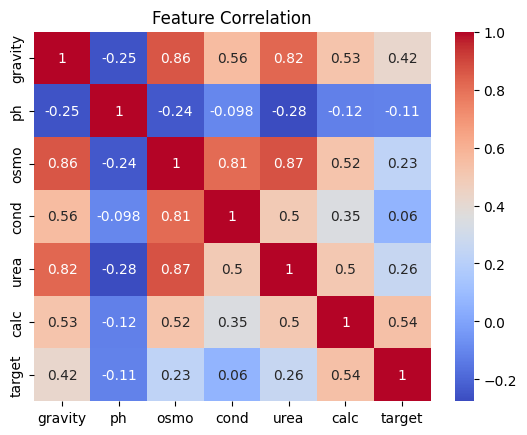

In [5]:
# Correlation heatmap
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

### Splitting the data into training and testing sets
Before splitting the data, we need to remove the target column from the dataset and store it in a separate variable and create a new dataset without the target column.

We also set the test size to 30% so that we can use 70% of the data for training and 30% for testing.

Also, we use the `random_state` parameter to ensure that the data is split in a reproducible way.

In [6]:
X = df.drop(columns=['target'])
y = df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Building and fitting the model

We started here by defining some parameters, these parameters are:
- `n_estimators`: This parameter specifies the number of boosting rounds or trees the model will build. More rounds can improve the model's performance but may also lead to overfitting. Imagine it as a tree that extends its branches to make a prediction; this parameter controls how many such trees the model will build.

- `learning_rate`: This parameter controls how much the model's weights are adjusted with respect to the loss gradient. A smaller learning rate means the model learns more slowly but can achieve better accuracy by preventing overfitting.


<div style="text-align: center;"><img src="https://miro.medium.com/v2/resize:fit:700/format:webp/0*xW7e6YxnX7V_HhsM.png" alt="Learning Rate Illustration"></div>

- `max_depth`: This parameter sets the maximum depth of each tree in the model. Deeper trees can capture more complex patterns but may also lead to overfitting.

- `random_state`: This parameter ensures that the random processes in the model (like data shuffling) produce the same results every time you run the code, making the results reproducible.

- `use_label_encoder`: This parameter determines whether to use a label encoder for the target variable, which converts categorical labels into numerical values that the model can understand. In our case, we don't need to use it because the target variable is already in numerical form.


In [8]:
# Define the model without class balancing
xgb_model = XGBClassifier(
    n_estimators=100,       # Number of boosting rounds
    learning_rate=0.1,      # Learning rate
    max_depth=3,            # Maximum depth of trees
    random_state=42,
    use_label_encoder=False
)

# Train the model
xgb_model.fit(X_train, y_train)

/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Model Evaluation

#### Accuracy
The accuracy of a model is a measure of how often the model correctly predicts the target variable. It is calculated as the number of correct predictions divided by the total number of predictions. While accuracy is a useful metric, it may not always provide a complete picture of the model's performance, especially in cases where the data is imbalanced.

#### Classification Report
The classification report provides a more detailed analysis of the model's performance. It includes several important metrics:
- `Precision`: This metric indicates the proportion of positive identifications that were actually correct. It is calculated as the number of true positives divided by the sum of true positives and false positives.
- `Recall`: Also known as sensitivity or true positive rate, recall measures the proportion of actual positives that were correctly identified by the model. It is calculated as the number of true positives divided by the sum of true positives and false negatives.
- `F1-score`: This metric is the harmonic mean of precision and recall, providing a single score that balances both concerns. It is particularly useful when you need to balance the trade-off between precision and recall.
- `Support`: This indicates the number of actual occurrences of the class in the dataset.

***By examining these metrics, we can gain a better understanding of the model's strengths and weaknesses, and make more informed decisions about how to improve its performance.***


In [9]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.67      0.80      0.73        10

    accuracy                           0.75        24
   macro avg       0.75      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



### Evaluating feature importance
Feature importance is a measure of how much each feature contributes to the model's prediction. It is calculated by looking at how much each feature helps the model make a prediction.

As can be seen below, the most important feature is the `calc` (Calcium Concentration) feature, and the least important feature is the `ph` (Urea pH) feature.


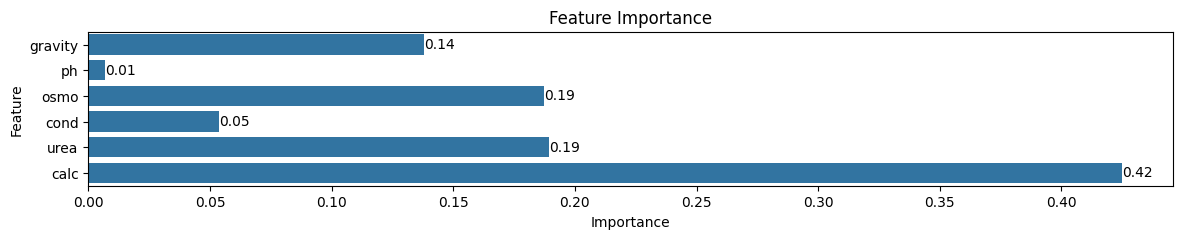

In [23]:
# Feature importance visualization
feature_importance = xgb_model.feature_importances_
plt.figure(figsize=(14, 2))
ax = sns.barplot(x=feature_importance, y=X.columns)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Write the number on the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')

plt.show()

### Confusion Matrix
The confusion matrix is a table that shows the number of true positives, false positives, true negatives, and false negatives. It is a great way to visualize the classification model's performance.

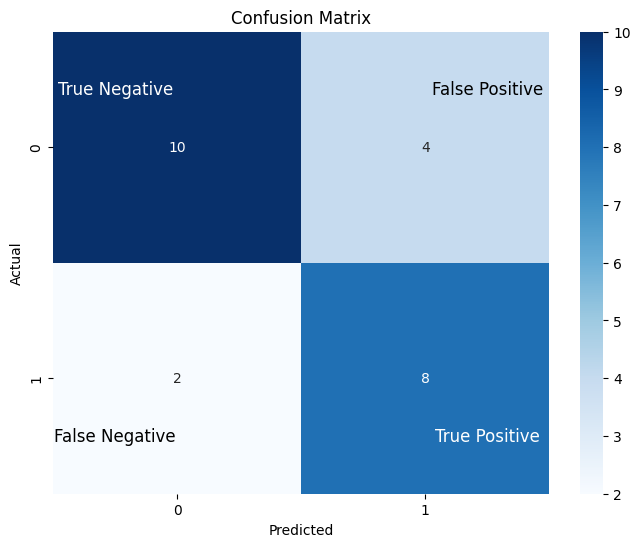

In [45]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Label the quadrants
plt.text(0.25, 0.25, 'True Negative', ha='center', va='center', color='white', fontsize=12)
plt.text(1.75, 0.25, 'False Positive', ha='center', va='center', color='black', fontsize=12)
plt.text(0.25, 1.75, 'False Negative', ha='center', va='center', color='black', fontsize=12)
plt.text(1.75, 1.75, 'True Positive', ha='center', va='center', color='white', fontsize=12)

plt.show()

### ROC-AUC Curve
The ROC-AUC curve is a plot that shows the true positive rate (TPR) and false positive rate (FPR) of the model at different thresholds. It is used to evaluate the performance of a classification model by illustrating the trade-off between the TPR and FPR.
The area under the curve (AUC) provides a single metric to summarize the model's performance. A higher AUC value indicates a better-performing model, with a value of 1 representing a perfect model and 0.5 representing a model with no discriminative power.


The ROC curve below has an AUC (Area Under the Curve) of 0.78, which indicates that the model performs better than random guessing (AUC = 0.5) but still leaves room for improvement.

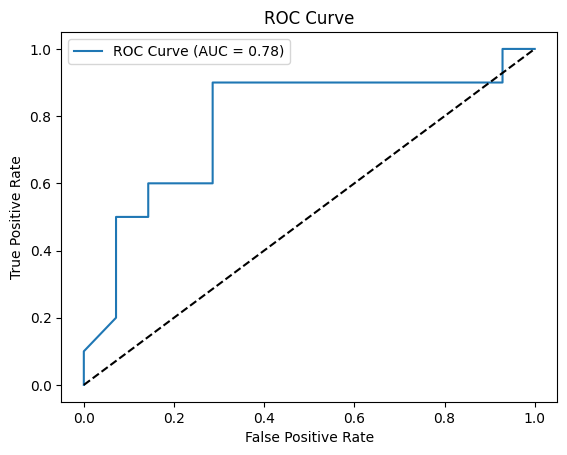

In [47]:
# ROC-AUC Curve
y_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Performing cross-validation
Cross-validation is a technique used to evaluate the performance of a model on a limited dataset. It involves splitting the dataset into multiple subsets, training the model on each subset, and then evaluating the model on the remaining subset. This helps to ensure that the model is not overfitting to the dataset and is generalizing well to new data.

In this case, we are using the `StratifiedKFold` class from the `sklearn.model_selection` module to perform stratified cross-validation. We are using 5 folds, which means that the dataset will be split into 5 subsets. We are also shuffling the data and setting the random state to 42 to ensure that the data is split in a reproducible way.

This way, we can get a better idea of the model's performance and how it generalizes to new data given that it has been tried on multiple subsets of the data.

`Below` is the code for performing cross-validation and plotting the results:
- Cross-Validation F1 Scores: [0.93333333 0.5        0.44444444 0.76923077 0.71428571]
- Mean F1 Score: 0.67
This means that the model is performing well on the dataset and is generalizing well to new data.


/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

Cross-Validation F1 Scores: [0.93333333 0.5        0.44444444 0.76923077 0.71428571]
Mean F1 Score: 0.67


/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


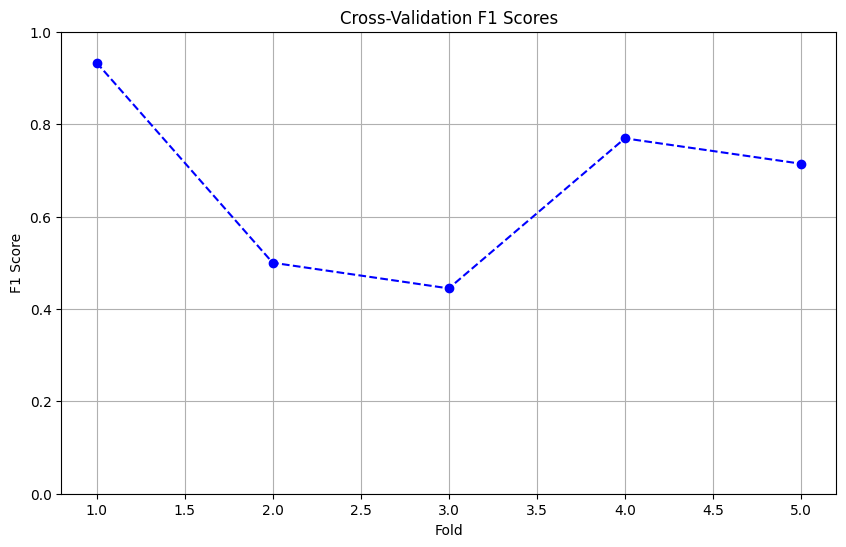

In [31]:
# Perform stratified cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X, y, cv=stratified_kfold, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.2f}")

# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation F1 Scores')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

### Grid Search
One way of improving the model's performance is by using Grid search. Grid search in simple words is a way of estimating the best parameters possible for the model that gives the best performance.

Let's see how we can use Grid search to improve the model's performance and compare it to before optimization.

We are defining here the range of parameters that we want to try and see which one gives the best performance.

In [49]:
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Step size for each tree
    'max_depth': [2, 3, 5],             # Maximum depth of trees
    'subsample': [0.8, 1.0],            # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 1.0],     # Fraction of features used for each tree
    'scale_pos_weight': [1, 45/34]      # Handle class imbalance
}

# Define the scoring metric
scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scorer,       # You can replace with 'accuracy', 'roc_auc', etc.
    cv=5,                 # Number of folds for cross-validation
    verbose=1,            # Display progress
    n_jobs=-1             # Use all available processors
)

# Perform GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_:.2f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.3235294117647058, 'subsample': 0.8}
Best F1 Score: 0.89


/Users/ahmedsameh/miniconda3/envs/work/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:27:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Evaluating the optimized model
As you can see below, the optimized model has a better performance than the previous model. The ROC-AUC curve is higher and the F1 score is higher.

<span style="color:deepskyblue">You can try to play with the parameters to see if you can get a better performance.</span>

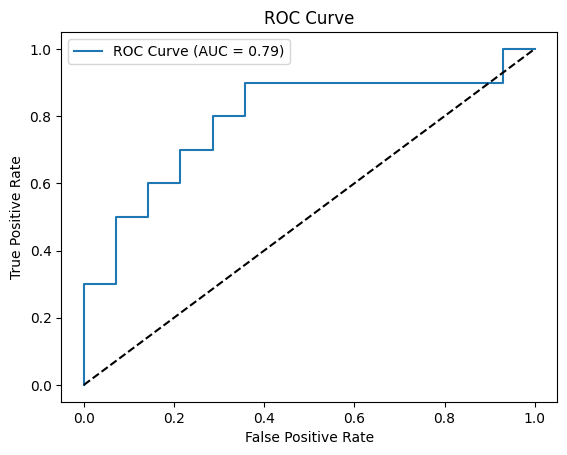

In [51]:
# ROC-AUC Curve
y_proba_optimized = grid_search.predict_proba(X_test)[:, 1]
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_proba_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_proba_optimized)

plt.plot(fpr_optimized, tpr_optimized, label=f'ROC Curve (AUC = {roc_auc_optimized:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Saving the model
We can save the model to a file using the `joblib` library. This will allow us to load the model later and use it for predictions.

In [52]:
joblib.dump(xgb_model, 'model/unoptimized_xgb_classifier.pkl')
print("Unoptimized model saved successfully in the following path: model/unoptimized_xgb_classifier.pkl")

joblib.dump(grid_search, 'model/optimized_xgb_classifier.pkl')
print("Optimized model saved successfully in the following path: model/optimized_xgb_classifier.pkl")

Unoptimized model saved successfully in the following path: model/unoptimized_xgb_classifier.pkl
Optimized model saved successfully in the following path: model/optimized_xgb_classifier.pkl
